# This notebook will be mainly used for my IBM Data Science capstone project

In [382]:
import numpy as np
import pandas as pd


from shapely.geometry import Point, Polygon
import geopandas as gpd #library to work with GeoJSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library

import matplotlib.pyplot as plt #library for plotting
!conda install -c conda-forge folium=0.5.0 --yes
import folium # library to create interactive maps

import googlemaps #library for Google Maps Service's API

from sklearn.cluster import KMeans 

Solving environment: done

# All requested packages already installed.



In [164]:
pd.set_option('display.max_columns', None)

In [165]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


<h1> Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods (Week 1) </h1>

# Introduction/Business Problem

The target group of this project are people who would like move to or within in Vancouver, BC and whose decision makeing criteria for selecting their future neighborhood is walking distance to important locations.

May the distance between the new home and the following locations be the most important factors for this target group:
    - nearest beach
    - nearest school
    - nearest coffee shop
    - nearest restaurant
    - nearest park

# Data  
The following is an explanation and discussion of the data that will be used (including examples).

### Geolocation of all of Vancouver, BC's blocks  
The city of Vancouver publishes all its block numberes and corresponding location data on its Open Data Portal: <a href='https://opendata.vancouver.ca/explore/dataset/block-numbers/information/?location=14,49.2706,-123.13172'>link</a>.

**Loading the data & checking the quality:**

In [316]:
bnr = gpd.read_file('data/block-numbers.geojson')

In [317]:
bnr.isnull()['geometry'].value_counts()

False    5809
Name: geometry, dtype: int64

**Converting the unit of the Coordinate Reference System (CRS) to metres so that we can calculate distances:**

In [318]:
#Initiating CRS
bnr.crs

{'init': 'epsg:4326'}

In [319]:
#Transforming the CRS to a system that uses meters as a unit of measurement
bnr_metres = bnr.to_crs(epsg=3153)

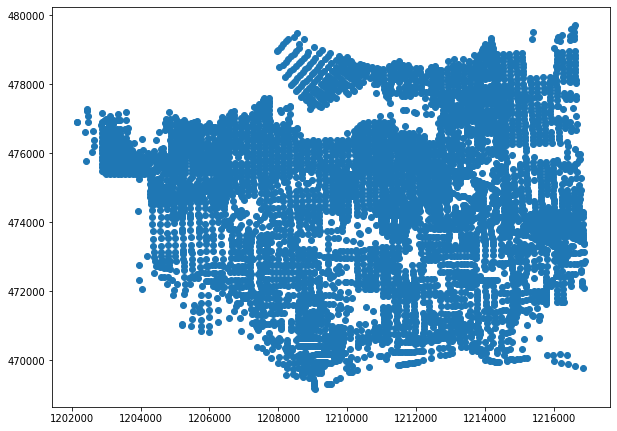

In [170]:
#Visualizing the Points
bnr_metres.plot(figsize=(10, 10))

**Foursquare**  
The Foursquare API provides information on locations of interest (beaches, schools, coffee shops, restaurants, grocery shops) 

In [171]:
CLIENT_ID = 'OJUT1X3N551XHV3QJEO2DHG4D4HJPGH1OXE32VZFJQCNNSDY' # my Foursquare ID
CLIENT_SECRET = '3LTK240VBKNGYARSYYFM3ZVTHRXSTF0344QJDABG2MKWNTP5' # my Foursquare Secret
VERSION = '20191112'
LIMIT = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OJUT1X3N551XHV3QJEO2DHG4D4HJPGH1OXE32VZFJQCNNSDY
CLIENT_SECRET:3LTK240VBKNGYARSYYFM3ZVTHRXSTF0344QJDABG2MKWNTP5


In [172]:
#Location data of a block & search parameters
latitude = pd.Series(bnr['geometry'])[0].y
longitude = pd.Series(bnr['geometry'])[0].x

search_query = 'Coffee Shop'
radius = 15000

In [173]:
# create URL
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    latitude, 
    longitude, 
    VERSION, 
    search_query, 
    radius, 
    LIMIT
)

url # display URL

'https://api.foursquare.com/v2/venues/search?client_id=OJUT1X3N551XHV3QJEO2DHG4D4HJPGH1OXE32VZFJQCNNSDY&client_secret=3LTK240VBKNGYARSYYFM3ZVTHRXSTF0344QJDABG2MKWNTP5&ll=49.2582443294326,-123.13528327239153&v=20191112&query=Coffee Shop&radius=15000&limit=1000'

In [174]:
#Sending the GET request and saving the resutls
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dd4d25860ba0800264e84eb'},
 'response': {'venues': [{'id': '586453fa0037eb3be739c864',
    'name': 'The Taste & See Coffee Shop',
    'location': {'address': '1628 West 1st Avenue #128',
     'lat': 49.270256,
     'lng': -123.141433,
     'labeledLatLngs': [{'label': 'display',
       'lat': 49.270256,
       'lng': -123.141433}],
     'distance': 1409,
     'cc': 'CA',
     'city': 'Vancouver',
     'state': 'BC',
     'country': 'Canada',
     'formattedAddress': ['1628 West 1st Avenue #128',
      'Vancouver BC',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'shortName': 'Coffee Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1574228583',
    'hasPerk': False},
   {'id': '57196f28498e2aeaefab44b2',
    'name': '7 Days Coffee Shop',
    

In [175]:
# Assign relevant part of JSON to venues
venues = results['response']['venues']
# Tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.shape

(50, 20)

In [176]:
# Keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# Clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

In [177]:
#Convert lan & lng into a Series with Point elements
point_ser = pd.Series([Point(x) for x in zip(dataframe_filtered['lng'], dataframe_filtered['lat'])])

In [178]:
#Add Point column
dataframe_filtered['geometry'] = point_ser
dataframe_filtered.head(3)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,geometry
0,The Taste & See Coffee Shop,Coffee Shop,1628 West 1st Avenue #128,CA,Vancouver,Canada,NaN,1409,"[1628 West 1st Avenue #128, Vancouver BC, Canada]","[{'label': 'display', 'lat': 49.270256, 'lng':...",49.270256,-123.141433,NaN,NaN,BC,586453fa0037eb3be739c864,POINT (-123.141433 49.270256)
1,7 Days Coffee Shop,Café,920 Beatty St.,CA,NaN,Canada,NaN,2278,"[920 Beatty St., Canada]","[{'label': 'display', 'lat': 49.275102, 'lng':...",49.275102,-123.117491,NaN,NaN,NaN,57196f28498e2aeaefab44b2,POINT (-123.117491 49.275102)
2,Laura's Coffee Shop,Diner,1945 Manitoba St.,CA,Vancouver,Canada,at 4th Ave.,2300,"[1945 Manitoba St. (at 4th Ave.), Vancouver BC...","[{'label': 'display', 'lat': 49.267427, 'lng':...",49.267427,-123.106913,NaN,V5Y 3A1,BC,4c48639e417b20a19bbfe0a9,POINT (-123.106913 49.267427)


In [179]:
#Convert to GeoDataFrame
geo_df = gpd.GeoDataFrame(dataframe_filtered)
#Initialize the Coordinate Reference System
geo_df.crs = {'init' :'epsg:4326'}
geo_df.head(3)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,geometry
0,The Taste & See Coffee Shop,Coffee Shop,1628 West 1st Avenue #128,CA,Vancouver,Canada,NaN,1409,"[1628 West 1st Avenue #128, Vancouver BC, Canada]","[{'label': 'display', 'lat': 49.270256, 'lng':...",49.270256,-123.141433,NaN,NaN,BC,586453fa0037eb3be739c864,POINT (-123.14143 49.27026)
1,7 Days Coffee Shop,Café,920 Beatty St.,CA,NaN,Canada,NaN,2278,"[920 Beatty St., Canada]","[{'label': 'display', 'lat': 49.275102, 'lng':...",49.275102,-123.117491,NaN,NaN,NaN,57196f28498e2aeaefab44b2,POINT (-123.11749 49.27510)
2,Laura's Coffee Shop,Diner,1945 Manitoba St.,CA,Vancouver,Canada,at 4th Ave.,2300,"[1945 Manitoba St. (at 4th Ave.), Vancouver BC...","[{'label': 'display', 'lat': 49.267427, 'lng':...",49.267427,-123.106913,NaN,V5Y 3A1,BC,4c48639e417b20a19bbfe0a9,POINT (-123.10691 49.26743)


**Converting the unit of the Coordinate Reference System (CRS) from degrees to metres so that we can interpret distances (<a href='https://epsg.io/3153'>link</a>):**

In [180]:
geo_df.to_crs(epsg=3153, inplace=True)

In [181]:
geo_df.head(2)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,geometry
0,The Taste & See Coffee Shop,Coffee Shop,1628 West 1st Avenue #128,CA,Vancouver,Canada,NaN,1409,"[1628 West 1st Avenue #128, Vancouver BC, Canada]","[{'label': 'display', 'lat': 49.270256, 'lng':...",49.270256,-123.141433,NaN,NaN,BC,586453fa0037eb3be739c864,POINT (1208166.445 476860.171)
1,7 Days Coffee Shop,Café,920 Beatty St.,CA,NaN,Canada,NaN,2278,"[920 Beatty St., Canada]","[{'label': 'display', 'lat': 49.275102, 'lng':...",49.275102,-123.117491,NaN,NaN,NaN,57196f28498e2aeaefab44b2,POINT (1209887.070 477468.878)


**Calcuating the distance between a venue of interest and a specific block:**

In [182]:
#Example: Find the distance between the first block and the first result of the search query
distance = bnr_metres['geometry'][0].distance(geo_df['geometry'][0])
print(f"The {str.lower(search_query)} is {int(distance)} metres away from the block.")

The coffee shop is 1407 metres away from the block.


<h1> Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods (Week 2) </h1>

## Gathering all data required in a way that does not exceed the quota of Foursquare's API:

1) Identify the location of all venues of interest  
1.1) Identify one central location point per neighborhood (centroid)  
1.2) Request all "Coffee Shop", "Restaurant", "School", "Beach", "Park" around each centroid  
1.3) Merge with results of other neighborhoods into one DataFrame and remove duplicates  
  
2) For each block in Vancouver, calculate the distance of the nearest venue per category  
2.1) Develop function to calculate the distance of the closest venue[i] for each block  
2.2) Calculate the distance of the closest venue for all venue types for each block

**1.1) Identifying one location point (centroid) per neighborhood**

In [326]:
area_names = bnr['geo_local_area'].unique()
area_names

array(['Fairview', 'Shaughnessy', 'Oakridge', 'Kerrisdale', 'Marpole',
       'Downtown', 'West End', 'South Cambie', 'Renfrew-Collingwood',
       'Killarney', 'Hastings-Sunrise', 'Mount Pleasant',
       'Grandview-Woodland', 'Strathcona', 'Riley Park', 'Arbutus-Ridge',
       'Kensington-Cedar Cottage', 'Victoria-Fraserview',
       'West Point Grey', 'Sunset', 'Kitsilano', 'Dunbar-Southlands',
       None], dtype=object)

In [327]:
#Return Series containing the point coordinates of all blocks in neighborhood i
def block_ser(i):
    return bnr[bnr['geo_local_area'] == area_names[i]]

In [328]:
#Return the Point of neighborhood i's centroid
def calc_centroid(i):    
    #Bounds =  minx, miny, maxx, maxy values
    bounds = block_ser(i)['geometry'].total_bounds
    #Calculate centroid of neighborhood i
    return Point((bounds[2]+bounds[0])/2, (bounds[3]+bounds[1])/2)

In [335]:
#Print centroid of first block in the a neighborhood
print(calc_centroid(1))

POINT (-123.1409310899415 49.24589120660731)


**1.2) Function requesting all "Beach", "Coffee Shop", "Restaurant", "School", "Park" around the centroit of a neighborhood**

In [358]:
#Initiating all values
venue_list = ['Beach', 'Coffee Shop', 'Restaurant', 'School', 'Park']
version = '20191112'
limit = 100 #As many as possible
radius = 2500 #Enough to cover the area of each neighborhood

In [359]:
#Return DataFrame with all venues=venue_list[i] in a given radius around the centroit of a given neighborhood 
def find_venues(neighborhood, radius, venue_from_list):
    # create URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        calc_centroid(neighborhood).y, 
        calc_centroid(neighborhood).x, 
        version, 
        venue_from_list, 
        radius, 
        limit
    )
    
    #Query Forsquare API
    results = requests.get(url).json()

    # Assign relevant part of JSON to venues
    venues = results['response']['venues']
    
    # Tranform venues into a dataframe
    dataframe = json_normalize(venues)
    
    # Keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # Clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    # Function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # Identify the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    
    #Convert lan & lng into a Series with Point elements
    point_ser = pd.Series([Point(x) for x in zip(dataframe_filtered['lng'], dataframe_filtered['lat'])])
    
    #Add columns with Points & Search Term
    dataframe_filtered['geometry'] = point_ser
    dataframe_filtered['venue_category'] = venue_from_list
    
    return dataframe_filtered

In [360]:
#Checking if function find_venues(neighborhood, radius, venue_from_list) returns the correct values
result_df = pd.DataFrame(find_venues(1, radius, venue_list[1]))

In [361]:
result_df.shape

(50, 18)

In [362]:
result_df.head(2)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,geometry,venue_category
0,The Coffee Shop,Café,2305 West 41st,CA,Vancouver,Canada,NaN,1860,"[2305 West 41st, Vancouver BC V6m, Canada]","[{'label': 'display', 'lat': 49.234648, 'lng':...",49.234648,-123.159866,NaN,V6m,BC,4c213b4d99282d7fde4865b0,POINT (-123.159866 49.234648),Coffee Shop
1,The Taste & See Coffee Shop,Coffee Shop,1628 West 1st Avenue #128,CA,Vancouver,Canada,NaN,2712,"[1628 West 1st Avenue #128, Vancouver BC, Canada]","[{'label': 'display', 'lat': 49.270256, 'lng':...",49.270256,-123.141433,NaN,NaN,BC,586453fa0037eb3be739c864,POINT (-123.141433 49.270256),Coffee Shop


**1.3) Saving all geolocations for venues "Beach", "Coffee Shop", "Restaurant", "School", "Park" in one DataFrame**

In [227]:
#Return DataFrame with all venues in a given radius around the centroit of all neighborhoods
def create_geo_df(radius):
    
    df = pd.DataFrame()
    
    #Loop through all neighborhoods
    for i in range(0,len(area_names)-1):
        
        #Loop through venue list
        for k in range(0,len(venue_list)):
                try:
                    df = pd.concat([df, find_venues(i, radius, venue_list[k]),], ignore_index=True, sort=False)
                except:
                    print(k)

    return df

In [228]:
#All venues including redundant listings!
result_df_all = create_geo_df(radius)

5
5
0
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [357]:
#Check number of venues including redundant entries
result_df_all.shape

(50, 18)

In [230]:
result_df_all

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id,geometry,venue_category,neighborhood
0,Sunset Beach,Beach,1400 Beach Ave,CA,Vancouver,Canada,at Broughton,1576,"[1400 Beach Ave (at Broughton), Vancouver BC V...","[{'label': 'display', 'lat': 49.27918658110156...",49.279187,-123.138885,V6E 1V7,BC,4aa7ffddf964a5209e4e20e3,POINT (-123.1388854980469 49.27918658110156),Beach,NaN
1,English Bay Beach,Beach,Beach Ave,CA,Vancouver,Canada,btwn Gilford & Bidwell,2451,"[Beach Ave (btwn Gilford & Bidwell), Vancouver...","[{'label': 'display', 'lat': 49.28661337371541...",49.286613,-123.142839,NaN,BC,4bcbdf5268f976b049e86183,POINT (-123.1428394441753 49.28661337371541),Beach,NaN
2,Kitsilano Beach,Beach,Cornwall Ave,CA,Vancouver,Canada,at Yew St,1923,"[Cornwall Ave (at Yew St), Vancouver BC V6K 1B...","[{'label': 'display', 'lat': 49.27355858778376...",49.273559,-123.154570,V6K 1B6,BC,4aa7e39df964a520dc4d20e3,POINT (-123.1545698436036 49.27355858778376),Beach,NaN
3,Beach Tower at 888 Beach,Residential Building (Apartment / Condo),1500 Hornby St,CA,Vancouver,Canada,at Beach St,1007,"[1500 Hornby St (at Beach St), Vancouver BC, C...","[{'label': 'display', 'lat': 49.27499597106359...",49.274996,-123.132937,NaN,BC,4bddf7c70ee3a593d1632fb0,POINT (-123.1329366530208 49.27499597106359),Beach,NaN
4,the beach house on cornwall,None,2012 Cornwall Avenue,CA,NaN,Canada,NaN,1586,"[2012 Cornwall Avenue, Canada]","[{'label': 'display', 'lat': 49.27208883893913...",49.272089,-123.150503,NaN,NaN,5289940211d2f357f551136d,POINT (-123.1505025926665 49.27208883893913),Beach,NaN
5,The Sigma Chi Beach House,None,1920 Yew St,CA,Vancouver,Canada,3rd & Yew,1791,"[1920 Yew St (3rd & Yew), Vancouver BC, Canada]","[{'label': 'display', 'lat': 49.269069, 'lng':...",49.269069,-123.154949,NaN,BC,4dabb1550437dccbd823ca42,POINT (-123.154949 49.269069),Beach,NaN
6,Bus C21 Yaletown/Beach,Bus Line,NaN,CA,Vancouver,Canada,NaN,2342,"[Vancouver BC, Canada]","[{'label': 'display', 'lat': 49.27563669928768...",49.275637,-123.101997,NaN,BC,4e46ea1dfa76a07fde60cc19,POINT (-123.1019971083714 49.27563669928768),Beach,NaN
7,Beach and Hornby st,Road,NaN,CA,Vancouver,Canada,Beach and Hornby st,942,"[Vancouver BC V6Z 1E1, Canada]","[{'label': 'display', 'lat': 49.27445273283521...",49.274453,-123.132416,V6Z 1E1,BC,4cd710922944b1f7505866ec,POINT (-123.1324157139366 49.27445273283521),Beach,NaN
8,Ocean Tower at 888 Beach,Building,1501 Howe Street,CA,Vancouver,Canada,NaN,945,"[1501 Howe Street, Vancouver BC V6Z 2P8, Canada]","[{'label': 'display', 'lat': 49.27450947860258...",49.274509,-123.132038,V6Z 2P8,BC,4d29f42f0fdc6a31b5138f0b,POINT (-123.132038458728 49.27450947860258),Beach,NaN
9,False Creek Ferries Sunset beach Dock,Boat or Ferry,NaN,CA,Vancouver,Canada,NaN,1248,"[Vancouver BC, Canada]","[{'label': 'display', 'lat': 49.27655892515106...",49.276559,-123.136784,NaN,BC,4e6295e1ae60e9edf5d30b3f,POINT (-123.1367839756393 49.27655892515106),Beach,NaN


In [281]:
#Dropping redundant venue entries
result_df_filtered = result_df_all.drop_duplicates('id', keep='first', inplace=False)

In [282]:
result_df_filtered.shape

(1601, 18)

In [349]:
#Checking if all categories are the desired categories
result_df_filtered['categories'].unique()

array(['Beach', 'Residential Building (Apartment / Condo)', None,
       'Bus Line', 'Road', 'Building', 'Boat or Ferry', 'Harbor / Marina',
       'School', 'Food & Drink Shop', 'Hotel', 'Salon / Barbershop',
       'Dog Run', "Dentist's Office", 'Real Estate Office', 'Event Space',
       'Café', 'Theater', 'Resort', 'Rest Area', 'Bed & Breakfast',
       'Playground', 'Tennis Court', "Doctor's Office", 'Coffee Shop',
       'Diner', 'Sandwich Place', 'Music Venue', 'Ice Cream Shop',
       'Smoke Shop', 'Flower Shop', 'Fish Market', 'Cosmetics Shop',
       'Clothing Store', 'Furniture / Home Store', 'Sporting Goods Shop',
       'Accessories Store', 'Dessert Shop',
       'General College & University', 'Taco Place', 'Toy / Game Store',
       'Seafood Restaurant', 'Chinese Restaurant',
       'Molecular Gastronomy Restaurant', 'Middle Eastern Restaurant',
       'Japanese Restaurant', 'Indian Restaurant', 'Lounge',
       'Dim Sum Restaurant', 'Sports Bar', 'Greek Restaurant',
   

In [350]:
#Manually filtering the categories
category_selection = ['Beach', 'Boat or Ferry', 'Harbor / Marina', 'School', 'Dog Run', 'Café', 
                      'Rest Area', 'Bed & Breakfast', 'Playground', 'Coffee Shop','Diner', 'Sandwich Place', 
                      'General College & University', 'Taco Place', 
                      'Seafood Restaurant', 'Chinese Restaurant', 'Molecular Gastronomy Restaurant', 
                      'Middle Eastern Restaurant', 'Japanese Restaurant', 'Indian Restaurant', 'Lounge',
                      'Dim Sum Restaurant', 'Sports Bar', 'Greek Restaurant',
                      'Korean Restaurant', 'Restaurant', 'Gastropub', 'Spanish Restaurant', 'Sushi Restaurant', 
                      'Szechuan Restaurant', 'Vegetarian / Vegan Restaurant', 'Thai Restaurant', 'Brewery',
                      'French Restaurant', 'Breakfast Spot', 'Asian Restaurant', 'American Restaurant', 
                      'Italian Restaurant', 'Elementary School', 'High School', 'College Academic Building', 
                      'Trade School', 'College Administrative Building', 'Music School', 'Other Great Outdoors', 
                      'Pub', 'Water Park', 'Waterfall', 'Cantonese Restaurant','Baseball Field', 'Plaza', 
                      'Scenic Lookout', 'Garden', 'Vietnamese Restaurant', 'Pakistani Restaurant',
                      'Field', 'Golf Course', 'Mountain', 'Fast Food Restaurant','Theme Restaurant','Pool', 
                      'Cuban Restaurant', 'Corporate Coffee Shop', 'Deli / Bodega', 'Cocktail Bar', 'Waterfront', 
                      'Food Truck', 'Sculpture Garden', 'Shanghai Restaurant', 'Mediterranean Restaurant', 
                      'Mexican Restaurant', 'Burger Joint', 'Bar', 'Pizza Place', 'Filipino Restaurant', 
                      'Tapas Restaurant', 'Hotpot Restaurant', 'Soup Place', 'Noodle House', 'Dumpling Restaurant', 
                      'Eastern European Restaurant', 'Theme Park Ride / Attraction', 'Malay Restaurant', 
                      'Portuguese Restaurant','North Indian Restaurant','Latin American Restaurant', 'Beer Garden', 
                      'Soccer Field', 'Ethiopian Restaurant', 'Food Service', 'Fish & Chips Shop', 
                      'Caribbean Restaurant', 'Skate Park', 'Smoothie Shop', 'Food']

In [363]:
#Removing categories that have been manually filtered out
result_df_filtered = result_df_filtered[result_df_filtered['categories'].isin(category_selection)]
result_df_filtered.shape

(900, 18)

In [283]:
#Saving the DataFrame in case I exceed my Foursquare quota
#result_df_filtered.to_csv(index=False)

In [364]:
#Converting the CRS to a format that uses metres so that we can interpret distances
result_gdf_filtered = gpd.GeoDataFrame(result_df_filtered)
result_gdf_filtered.crs = {'init' :'epsg:4326'}
result_gdf_filtered = result_gdf_filtered.to_crs(epsg=3153)

In [371]:
result_gdf_filtered.head(3)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id,geometry,venue_category,neighborhood
0,Sunset Beach,Beach,1400 Beach Ave,CA,Vancouver,Canada,at Broughton,1576,"[1400 Beach Ave (at Broughton), Vancouver BC V...","[{'label': 'display', 'lat': 49.27918658110156...",49.279187,-123.138885,V6E 1V7,BC,4aa7ffddf964a5209e4e20e3,POINT (1208311.764 477859.167),Beach,NaN
1,English Bay Beach,Beach,Beach Ave,CA,Vancouver,Canada,btwn Gilford & Bidwell,2451,"[Beach Ave (btwn Gilford & Bidwell), Vancouver...","[{'label': 'display', 'lat': 49.28661337371541...",49.286613,-123.142839,NaN,BC,4bcbdf5268f976b049e86183,POINT (1207990.744 478672.098),Beach,NaN
2,Kitsilano Beach,Beach,Cornwall Ave,CA,Vancouver,Canada,at Yew St,1923,"[Cornwall Ave (at Yew St), Vancouver BC V6K 1B...","[{'label': 'display', 'lat': 49.27355858778376...",49.273559,-123.154570,V6K 1B6,BC,4aa7e39df964a520dc4d20e3,POINT (1207195.565 477188.295),Beach,NaN


**2.1) Functions to calculate the distance of the closest venue[i] for each block**

In [372]:
#Function that returns a Series that contains the venue closest to the point given only
def min_dist(point, venues):
    
    #For each venue, calculate the distance to the point given
    venues['distance'] = venues.apply(lambda x: point.distance(x.geometry),axis=1)
    
    #idxmin returns the row label of the minimum value
    #Filter test_venues so that only the one row gets returned that contains the venue closest to the point given
    geoseries = venues.iloc[venues['distance'].idxmin()] 

    return geoseries

In [373]:
#Function to return a gdf containing all venues in gdf result_gdf_filtered of type venue_list[i] 
def create_venue_gdf(element):
    return result_gdf_filtered[result_gdf_filtered['venue_category']==venue_list[element]].reset_index()

In [368]:
#Function to calculate the distance of the nearest venue[i] for each block 
def nearest_venue(k):
    return bnr_metres.apply(lambda x: min_dist(x.geometry,create_venue_gdf(k))['distance'] , axis=1)

**2.2) Adding the distance of the closest venue for all venue types for each block to bnr_metres**

In [369]:
#Calculate the distance of the nearest venue for all venue tyepes for each block 
for i in range(0, len(venue_list)):
    bnr_metres['Distance to nearest '+venue_list[i]] = nearest_venue(i)

In [370]:
bnr_metres

,label,geo_local_area,geometry,Distance to nearest Beach,Distance to nearest Coffee Shop,Distance to nearest Restaurant,Distance to nearest School,Distance to nearest Park
0,452,Fairview,POINT (1208668.030 475544.723),1574.956038,637.165087,327.524396,291.672766,633.225682
1,50,Shaughnessy,POINT (1208496.928 475297.044),1491.520272,836.294235,441.968371,539.991621,517.558853
2,370,Fairview,POINT (1208300.480 475953.593),1166.790158,209.411969,150.801689,141.446537,323.963213
3,430,Fairview,POINT (1208304.731 475643.380),1198.797380,498.120910,124.154731,450.631312,292.465508
4,429,Fairview,POINT (1208131.420 475640.473),1031.080699,546.515092,278.639685,475.796058,146.348910
5,409,Fairview,POINT (1208130.757 475742.642),1009.103157,457.842420,251.793662,380.138176,232.851289
6,389,Fairview,POINT (1208135.506 475849.112),1002.316369,376.531651,236.677012,282.522331,252.586506
7,352,Fairview,POINT (1208646.354 476061.863),1426.960126,241.481127,86.151065,369.917738,652.470531
8,431,Fairview,POINT (1208505.917 475646.187),1395.317932,491.655385,136.517596,456.850421,484.974241
9,411,Fairview,POINT (1208491.939 475748.032),1366.208214,389.022338,97.978783,406.218558,506.146753


## Clustering blocks based on nearest distance to venues

In [380]:
#Creating the dataframe which we use K-means on
distances = bnr_metres.drop(['label', 'geo_local_area', 'geometry'], axis=1)
distances.head(2)

,Distance to nearest Beach,Distance to nearest Coffee Shop,Distance to nearest Restaurant,Distance to nearest School,Distance to nearest Park
0,1574.956038,637.165087,327.524396,291.672766,633.225682
1,1491.520272,836.294235,441.968371,539.991621,517.558853


In [435]:
#Setting number of clusters
clusters = 4

#Runging k-means clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(distances)

#Checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 0, 0, 0, 0, 0, 3, 3, 3], dtype=int32)

In [513]:
kmeans_ser = pd.Series(kmeans.labels_)
kmeans_ser.values

array([3, 3, 0, ..., 3, 0, 0], dtype=int32)

In [538]:
#Creating a DataFrame to visualize the geographical distribution of the clusters
bnr_clusters = bnr_metres[['geometry']]
bnr_clusters['cluster'] = pd.Series(kmeans_ser.values)
bnr_clusters.head(2)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,geometry,cluster
0,POINT (1208668.030 475544.723),3
1,POINT (1208496.928 475297.044),3


In [539]:
#Convert CRS to a format that Folium can use
bnr_clusters = bnr_clusters.to_crs(4326)
bnr_clusters.head(2)

,geometry,cluster
0,POINT (-123.13528 49.25824),3
1,POINT (-123.13777 49.25608),3


## Visualizing clusters

In [540]:
#Defining the world map centered around Vancouver, BC with a low zoom level
latitude = 49.25621
longitude = -123.12096
vancouver_map = folium.Map(location=[latitude, longitude], zoom_start=12)


In [541]:
block_list=[]
color_list=['indigo', 'yellow', 'seagreen', 'dimgrey', 'limegreen', 'gold']

#Adding color coded markers to map
for i in range(clusters):
    
    block_list.append(folium.map.FeatureGroup())
    
    #Looping through bnr_clusters and add each to the blocks feature group
    for lat, lng, in zip(bnr_clusters[bnr_clusters['cluster']==i]['geometry'].y, bnr_clusters[bnr_clusters['cluster']==i]['geometry'].x):
        block_list[i].add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=3, # define how big you want the circle markers to be
                color=color_list[i],
                fill=True,
                fill_color=color_list[i],
                fill_opacity=0.6
            )
        )

    legend_name='Walk clusters'
    
    #Adding blocks to map
    vancouver_map.add_child(block_list[i])

In [542]:
#Saving output as html 
vancouver_map.save('vancouver_map.html')

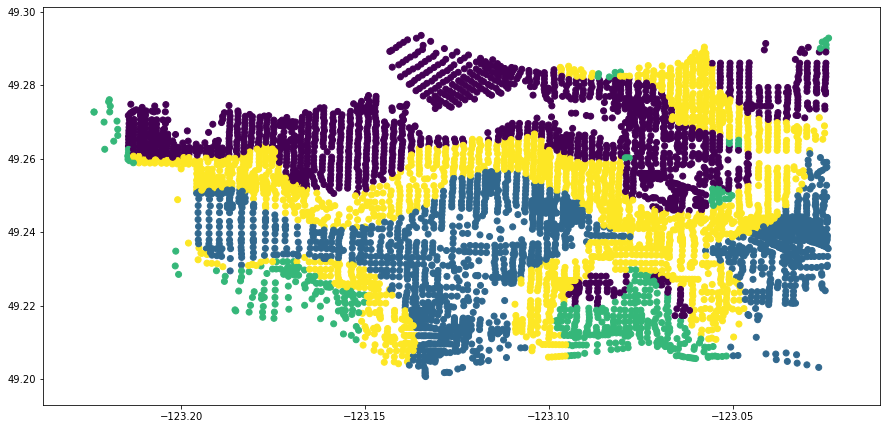

In [439]:
#Plotting in Jupyter Notebook:
fig, ax = plt.subplots(figsize=(15,20), subplot_kw={'aspect':'equal'})
bnr_clusters.plot(column='cluster', ax=ax)

## Interpretation of clusters

In [524]:
distances['cluster'] = bnr_clusters['cluster']

**Cluster 0, color = indigo blue (location-wise, this is as good as it gets):**

In [527]:
distances[distances['cluster']==0].head(5)

,Distance to nearest Beach,Distance to nearest Coffee Shop,Distance to nearest Restaurant,Distance to nearest School,Distance to nearest Park,cluster
2,1166.790158,209.411969,150.801689,141.446537,323.963213,0
3,1198.797380,498.120910,124.154731,450.631312,292.465508,0
4,1031.080699,546.515092,278.639685,475.796058,146.348910,0
5,1009.103157,457.842420,251.793662,380.138176,232.851289,0
6,1002.316369,376.531651,236.677012,282.522331,252.586506,0


**Cluster 1, color = yellow (No beach, no coffee):**

In [528]:
distances[distances['cluster']==1].head(5)

,Distance to nearest Beach,Distance to nearest Coffee Shop,Distance to nearest Restaurant,Distance to nearest School,Distance to nearest Park,cluster
15,2974.780548,1098.071144,331.984203,796.176933,542.285244,1
16,3020.610820,1238.898468,243.692365,574.583413,213.756382,1
17,3198.949794,1258.954591,330.941160,699.143213,97.028869,1
18,3125.304774,1235.680323,270.885975,961.313657,426.215458,1
19,2552.900333,1011.950013,775.070982,886.305462,741.066421,1


**Cluster 2, color = seagreen (Get a bike!):**

In [529]:
distances[distances['cluster']==2].head(5)

,Distance to nearest Beach,Distance to nearest Coffee Shop,Distance to nearest Restaurant,Distance to nearest School,Distance to nearest Park,cluster
236,1137.800176,1058.875194,1281.930865,679.684455,1009.872014,2
237,1064.909826,786.169156,974.945673,478.448386,718.063515,2
295,1624.964473,2253.301194,714.745235,898.142217,1113.878027,2
297,1345.390916,1491.365214,1765.536044,1257.046645,2303.714368,2
316,1139.625377,751.762768,453.626303,352.873764,1021.957906,2


**Cluster 3, color = dimgrey (All but the beach):**

In [530]:
distances[distances['cluster']==3].head(5)

,Distance to nearest Beach,Distance to nearest Coffee Shop,Distance to nearest Restaurant,Distance to nearest School,Distance to nearest Park,cluster
0,1574.956038,637.165087,327.524396,291.672766,633.225682,3
1,1491.520272,836.294235,441.968371,539.991621,517.558853,3
7,1426.960126,241.481127,86.151065,369.917738,652.470531,3
8,1395.317932,491.655385,136.517596,456.850421,484.974241,3
9,1366.208214,389.022338,97.978783,406.218558,506.146753,3
